# Long Short-Term Memory (LSTM)

# Explanation

### What is LSTM? 
LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. 
LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images.
This finds application in speech recognition, machine translation, etc. LSTM is a special kind of RNN, which shows outstanding performance on a large variety of problems.

worth watching: https://www.youtube.com/watch?v=b61DPVFX03I&t=329s

## Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import src.make_dataset as md

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


## Getting the data


In [2]:
ts_ds_container_cpu = md.TimeSeriesDataSet("data/container_cpu_usage_seconds_2022-06-04_15_00_00_to_2022-06-04_18_00_00__3_hours.csv")

df = ts_ds_container_cpu.get_data_frame()
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]


# Showing data samples

In [3]:
df.head()


,argo-server thoth-middletier-prod oct-03-00-compute argo-server-6b5667f7cd-ghq4b,bridge-marker openshift-cnv oct-03-00-compute bridge-marker-mn5xp,registry-server openshift-marketplace oct-03-00-compute certified-operators-f8khc,collector openshift-logging oct-03-00-compute collector-wr2fd,logfilesmetricexporter openshift-logging oct-03-00-compute collector-wr2fd,registry-server openshift-marketplace oct-03-00-compute community-operators-p8tnz,coredns openshift-kni-infra oct-03-00-compute coredns-oct-03-00-compute,coredns-monitor openshift-kni-infra oct-03-00-compute coredns-oct-03-00-compute,csi-rbdplugin openshift-storage oct-03-00-compute csi-rbdplugin-lm89v,dns openshift-dns oct-03-00-compute dns-default-kkbl8,...,kube-scheduler-recovery-controller openshift-kube-scheduler oct-10-06-control openshift-kube-scheduler-oct-10-06-control,kube-scheduler-operator-container openshift-kube-scheduler-operator oct-10-06-control openshift-kube-scheduler-operator-58797bc45d-fhxng,packageserver openshift-operator-lifecycle-manager oct-10-06-control packageserver-659d94cd47-9gqdg,sdn-controller openshift-sdn oct-10-06-control sdn-controller-h7n9b,kube-rbac-proxy openshift-sdn oct-10-06-control sdn-qdp64,sdn openshift-sdn oct-10-06-control sdn-qdp64,service-ca-controller openshift-service-ca oct-10-06-control service-ca-7b78fcc549-9nndp,tuned openshift-cluster-node-tuning-operator oct-10-06-control tuned-l72lv,vertical-pod-autoscaler openshift-vertical-pod-autoscaler oct-10-06-control vpa-recommender-default-69bf66f869-gdwtb,vertical-pod-autoscaler openshift-vertical-pod-autoscaler oct-10-06-control vpa-updater-default-f85f5c89-nksb6
2022-06-04 15:06:00,0.000733,0.000191,0.110957,0.225678,0.003652,0.161002,0.004199,0.007211,0.001191,0.014941,...,0.000214,0.007018,0.017918,0.000670,0.000246,0.013745,0.007976,0.000170,0.005407,0.003712
2022-06-04 15:12:00,0.000652,0.000382,0.078167,0.211408,0.003837,0.120099,0.004422,0.006146,0.001277,0.015519,...,0.000225,0.007165,0.013296,0.000645,0.000264,0.012507,0.007544,0.000240,0.004810,0.004201
2022-06-04 15:18:00,0.000678,0.000259,0.076932,0.209000,0.003837,0.233175,0.004408,0.007131,0.001168,0.017394,...,0.000182,0.007561,0.018333,0.000653,0.000201,0.016379,0.007582,0.000168,0.005772,0.003655
2022-06-04 15:24:00,0.000675,0.000213,0.082030,0.218768,0.003818,0.123905,0.004396,0.006219,0.001353,0.016193,...,0.000195,0.007156,0.013953,0.000826,0.000179,0.010785,0.008241,0.000162,0.005604,0.003451
2022-06-04 15:30:00,0.000485,0.000252,0.102423,0.240956,0.007088,0.039365,0.004373,0.005976,0.001130,0.016840,...,0.000191,0.007400,0.017201,0.000904,0.000176,0.011963,0.008195,0.000208,0.005105,0.003792


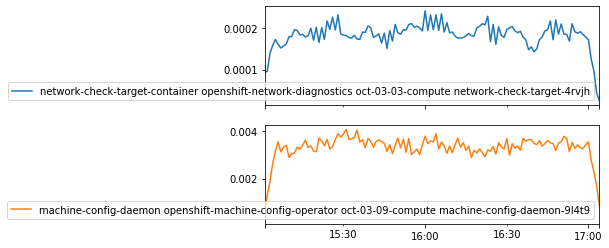

In [4]:
ts_ds_container_cpu.plot_random_samples(2)

In [5]:
ts_ds_container_cpu.get_dataset_description()

,count,mean,std,min,25%,50%,75%,max
argo-server thoth-middletier-prod oct-03-00-compute argo-server-6b5667f7cd-ghq4b,124.0,0.000547,0.000105,0.000062,0.000502,0.000544,0.000607,0.000783
bridge-marker openshift-cnv oct-03-00-compute bridge-marker-mn5xp,124.0,0.000255,0.000079,0.000010,0.000205,0.000252,0.000303,0.000467
registry-server openshift-marketplace oct-03-00-compute certified-operators-f8khc,124.0,0.094805,0.050735,0.000921,0.056396,0.083764,0.121233,0.240537
collector openshift-logging oct-03-00-compute collector-wr2fd,124.0,0.214465,0.061454,0.029615,0.192282,0.207799,0.221026,0.495754
logfilesmetricexporter openshift-logging oct-03-00-compute collector-wr2fd,124.0,0.004438,0.003725,0.000268,0.003013,0.003324,0.003796,0.023704
...,...,...,...,...,...,...,...,...
sdn openshift-sdn oct-10-06-control sdn-qdp64,124.0,0.012954,0.002651,0.002121,0.011876,0.013021,0.014342,0.022134
service-ca-controller openshift-service-ca oct-10-06-control service-ca-7b78fcc549-9nndp,124.0,0.007521,0.001112,0.001109,0.007496,0.007707,0.007918,0.008935
tuned openshift-cluster-node-tuning-operator oct-10-06-control tuned-l72lv,124.0,0.000183,0.000032,0.000041,0.000169,0.000178,0.000199,0.000257
vertical-pod-autoscaler openshift-vertical-pod-autoscaler oct-10-06-control vpa-recommender-default-69bf66f869-gdwtb,124.0,0.005041,0.000804,0.001836,0.004680,0.005035,0.005462,0.007167


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def plot(self, model, plot_col, max_subplots):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [11]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [13]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# LSTM

In [22]:
wide_window = WindowGenerator(
    input_width=125, label_width=24, shift=1,
    label_columns=[df.columns[0]])

wide_window

Total window size: 126
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]
Label indices: [102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125]
Label column name(s): ['argo-server thoth-middletier-prod oct-03-00-compute argo-server-6b5667f7cd-ghq4b']

In [23]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [24]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


StopIteration: 

In [17]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()

Epoch 1/20


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
wide_window.plot(lstm_model)
